# Loan Prediction 

In [136]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, auc, mutual_info_score, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier

In [137]:
df = pd.read_csv("loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.486462,3.0,561,Yes,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.081420,2.0,504,Yes,1
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.442193,3.0,635,Yes,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.438855,2.0,675,Yes,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.529221,4.0,586,Yes,1


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## EDA

In [139]:
df_full_train, df_test = train_test_split(df, test_size=0.2,)
df_train, df_val = train_test_split(df_full_train, test_size=0.25,)
len(df_train), len(df_val), len(df_test)

(27000, 9000, 9000)

In [140]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [141]:
y_train = df_train.loan_status.values
y_val = df_val.loan_status.values
y_test = df_test.loan_status.values

In [142]:
del df_train["loan_status"]
del df_val["loan_status"]
del df_test["loan_status"]

In [143]:
cat_cols = [var for var in df.columns if df[var].dtypes == 'object']
num_cols = [var for var in df.columns if df[var].dtypes != 'object']

print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


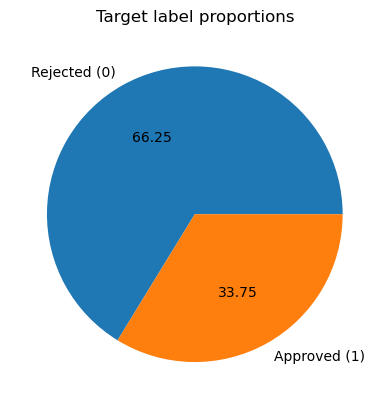

In [144]:
label_prop = df["loan_status"].value_counts()

plt.pie(label_prop.values, labels=["Rejected (0)", "Approved (1)"], autopct="%.2f")
plt.title("Target label proportions")
plt.show()

In [145]:
global_loan_rate = (df_full_train.loan_status.mean())

female_loan = df_full_train[df_full_train.person_gender == "female"].loan_status.mean()
male_loan = df_full_train[df_full_train.person_gender == "male"].loan_status.mean()

print(f" Female Loan rate: {female_loan:.3f}\n Male Loan rate: {male_loan:.3f}\n Global Loan rate:  {global_loan_rate:.3f}")

 Female Loan rate: 0.334
 Male Loan rate: 0.337
 Global Loan rate:  0.336


In [146]:
from IPython.display import display

for c in cat_cols:
    print(c)
    df_group = df_full_train.groupby(c).loan_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_loan_rate
    df_group['risk'] = df_group['mean'] / global_loan_rate
    display(df_group)
    print("\n\n")

person_gender


,mean,count,diff,risk
person_gender,,,,
female,0.333624,16072,-0.002126,0.993667
male,0.337465,19928,0.001715,1.005108





person_education


,mean,count,diff,risk
person_education,,,,
Associate,0.344899,9597,0.009149,1.027251
Bachelor,0.320699,10764,-0.015051,0.955171
Doctorate,0.210526,494,-0.125224,0.627033
High School,0.382371,9564,0.046621,1.138857
Master,0.280237,5581,-0.055513,0.834658





person_home_ownership


,mean,count,diff,risk
person_home_ownership,,,,
MORTGAGE,0.264610,14750,-0.071140,0.788117
OTHER,0.478261,92,0.142511,1.424455
OWN,0.353937,2362,0.018187,1.054169
RENT,0.388593,18796,0.052843,1.157389





loan_intent


,mean,count,diff,risk
loan_intent,,,,
DEBTCONSOLIDATION,0.356342,5708,0.020592,1.061331
EDUCATION,0.335154,7325,-0.000596,0.998224
HOMEIMPROVEMENT,0.333680,3848,-0.002070,0.993834
MEDICAL,0.351249,6847,0.015499,1.046161
PERSONAL,0.324445,6038,-0.011305,0.966330
VENTURE,0.312801,6234,-0.022949,0.931648





previous_loan_defaults_on_file


,mean,count,diff,risk
previous_loan_defaults_on_file,,,,
No,0.197702,29074,-0.138048,0.588838
Yes,0.915247,6926,0.579497,2.725977


In [147]:
mi = {}
for c in cat_cols:
    mi[c] = mutual_info_score(df_full_train[c], df_full_train.loan_status)

pd.Series(mi).sort_values(ascending=False)

previous_loan_defaults_on_file    0.180795
person_home_ownership             0.008192
person_education                  0.003098
loan_intent                       0.000507
person_gender                     0.000008
dtype: float64

In [148]:
num_cols_for_mi = [c for c in num_cols if c != "loan_status"]
mi_scores = mutual_info_classif(df_full_train[num_cols_for_mi], df_full_train.loan_status)

mi = dict(zip(num_cols_for_mi, mi_scores))
pd.Series(mi).sort_values(ascending=False)

loan_percent_income           0.136955
credit_score                  0.080482
loan_int_rate                 0.061672
loan_amnt                     0.044165
person_income                 0.032814
cb_person_cred_hist_length    0.029125
person_age                    0.019156
person_emp_exp                0.009667
dtype: float64

In [149]:
df_full_train[num_cols].corrwith(df_full_train.loan_status)

person_age                   -0.132592
person_income                -0.129239
person_emp_exp               -0.127014
loan_amnt                     0.279336
loan_int_rate                 0.321956
loan_percent_income           0.503106
cb_person_cred_hist_length   -0.144133
credit_score                 -0.391593
loan_status                   1.000000
dtype: float64

## One hot encoding

In [150]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat_cols + num_cols_for_mi].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cat_cols + num_cols_for_mi].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Model

In [151]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [152]:
y_pred = model.predict_proba(X_val)[:, 1]

loan_des = (y_pred >= 0.5)

(y_val == loan_des).mean()

np.float64(0.8165555555555556)

In [153]:
scores = []
thresholds = np.linspace(0, 1, 21)

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t, score))
    scores.append(score)

0.00 0.344
0.05 0.571
0.10 0.660
0.15 0.710
0.20 0.748
0.25 0.773
0.30 0.789
0.35 0.804
0.40 0.811
0.45 0.817
0.50 0.817
0.55 0.815
0.60 0.811
0.65 0.806
0.70 0.794
0.75 0.782
0.80 0.768
0.85 0.747
0.90 0.727
0.95 0.698
1.00 0.656


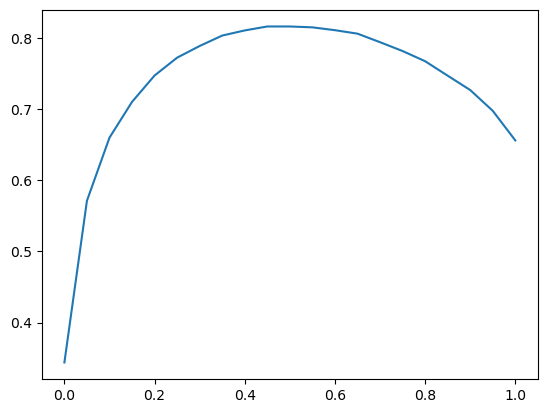

In [154]:
plt.plot(thresholds, scores)

## Model Evaluation Metrics

In [155]:
y_pred_binary = (y_pred >= 0.5).astype(int)

metrics = {
    "Accuracy": accuracy_score(y_val, y_pred_binary),
    "Precision": precision_score(y_val, y_pred_binary),
    "Recall": recall_score(y_val, y_pred_binary),
    "F1-Score": f1_score(y_val, y_pred_binary),
    "ROC-AUC": roc_auc_score(y_val, y_pred)
}

metrics_summary = (
    pd.Series(metrics, name="Score")
      .rename_axis("Metric")
      .reset_index()
)

print("Validation snapshot")
print(metrics_summary.to_string(index=False))



Validation snapshot
   Metric    Score
 Accuracy 0.816556
Precision 0.773814
   Recall 0.659017
 F1-Score 0.711817
  ROC-AUC 0.882201



CONFUSION MATRIX:
[[5310  596]
 [1055 2039]]

Interpretation:
True Negatives (TN):  5310
False Positives (FP): 596
False Negatives (FN): 1055
True Positives (TP):  2039


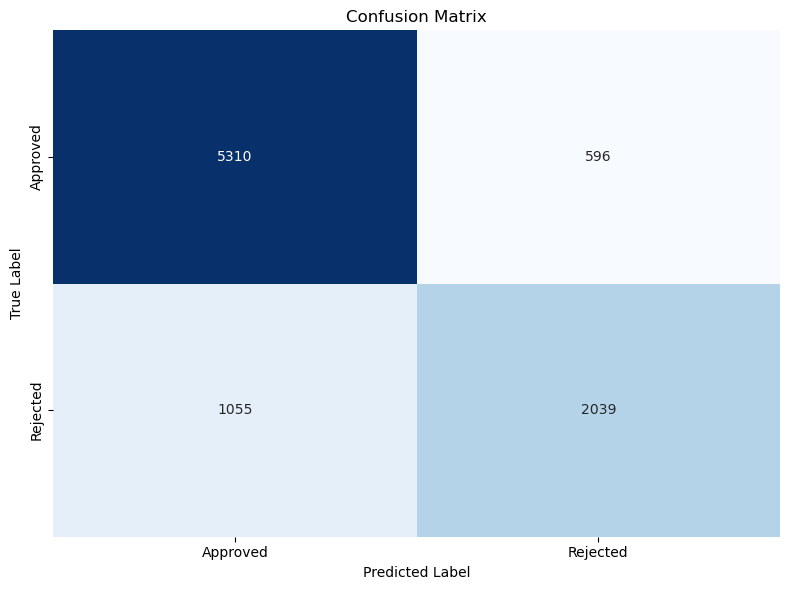

In [156]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_binary)
print("\nCONFUSION MATRIX:")
print(cm)
print("\nInterpretation:")
print(f"True Negatives (TN):  {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP):  {cm[1,1]}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Approved', 'Rejected'],
            yticklabels=['Approved', 'Rejected'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [157]:
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_val, y_pred_binary, 
                           target_names=['Approved (0)', 'Rejected (1)']))



DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

Approved (0)       0.83      0.90      0.87      5906
Rejected (1)       0.77      0.66      0.71      3094

    accuracy                           0.82      9000
   macro avg       0.80      0.78      0.79      9000
weighted avg       0.81      0.82      0.81      9000



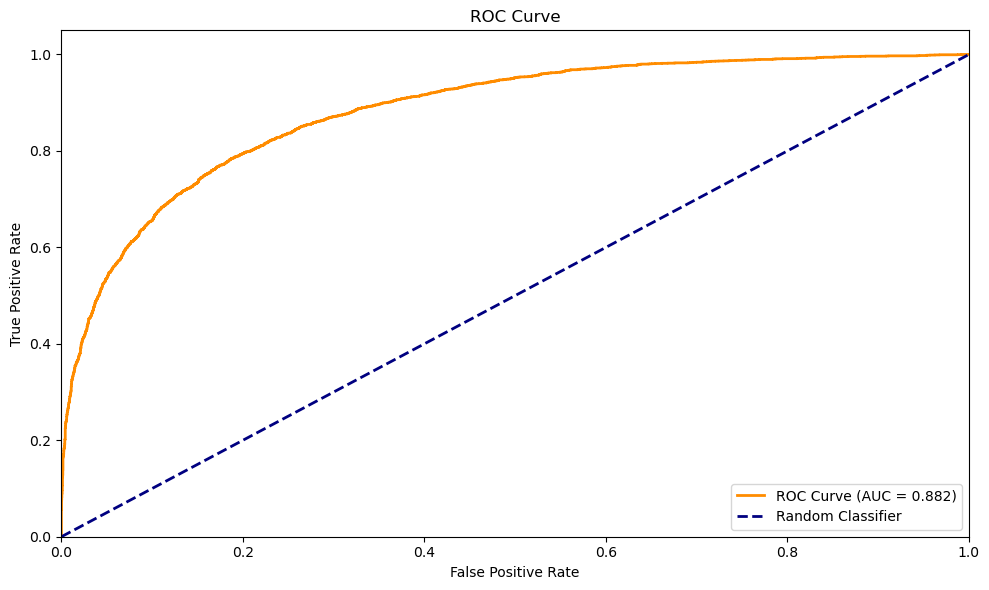

In [158]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [159]:
# For Test Data set 
test_dict = df_test[cat_cols + num_cols_for_mi].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_pred_test = model.predict_proba(X_test)[:, 1]
y_pred_test_binary = (y_pred_test >= 0.5).astype(int)

lr_test_accuracy = accuracy_score(y_test, y_pred_test_binary)
lr_test_precision = precision_score(y_test, y_pred_test_binary)
lr_test_recall = recall_score(y_test, y_pred_test_binary)
lr_test_f1 = f1_score(y_test, y_pred_test_binary)
lr_test_roc_auc = roc_auc_score(y_test, y_pred_test)

print("LOGISTIC REGRESSION - TEST SET RESULTS")
print(f"Accuracy:  {lr_test_accuracy:.4f}")
print(f"Precision: {lr_test_precision:.4f}")
print(f"Recall:    {lr_test_recall:.4f}")
print(f"F1-Score:  {lr_test_f1:.4f}")
print(f"ROC-AUC:   {lr_test_roc_auc:.4f}")


LOGISTIC REGRESSION - TEST SET RESULTS
Accuracy:  0.8154
Precision: 0.7711
Recall:    0.6599
F1-Score:  0.7112
ROC-AUC:   0.8829


# Trying different models

### Random Forest Model

In [160]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [161]:
rf_pred_val = rf_model.predict_proba(X_val)[:, 1]
rf_pred_val_binary = (rf_pred_val >= 0.5).astype(int)

rf_val_accuracy = accuracy_score(y_val, rf_pred_val_binary)
rf_val_precision = precision_score(y_val, rf_pred_val_binary)
rf_val_recall = recall_score(y_val, rf_pred_val_binary)
rf_val_f1 = f1_score(y_val, rf_pred_val_binary)
rf_val_roc_auc = roc_auc_score(y_val, rf_pred_val)

print("RANDOM FOREST - VALIDATION SET RESULTS")
print(f"Accuracy:  {rf_val_accuracy:.4f}")
print(f"Precision: {rf_val_precision:.4f}")
print(f"Recall:    {rf_val_recall:.4f}")
print(f"F1-Score:  {rf_val_f1:.4f}")
print(f"ROC-AUC:   {rf_val_roc_auc:.4f}")

RANDOM FOREST - VALIDATION SET RESULTS
Accuracy:  0.9023
Precision: 0.8805
Recall:    0.8284
F1-Score:  0.8536
ROC-AUC:   0.9603


In [162]:
# test set
rf_pred_test = rf_model.predict_proba(X_test)[:, 1]
rf_pred_test_binary = (rf_pred_test >= 0.5).astype(int)

rf_test_accuracy = accuracy_score(y_test, rf_pred_test_binary)
rf_test_precision = precision_score(y_test, rf_pred_test_binary)
rf_test_recall = recall_score(y_test, rf_pred_test_binary)
rf_test_f1 = f1_score(y_test, rf_pred_test_binary)
rf_test_roc_auc = roc_auc_score(y_test, rf_pred_test)

print("RANDOM FOREST - TEST SET RESULTS")
print(f"Accuracy:  {rf_test_accuracy:.4f}")
print(f"Precision: {rf_test_precision:.4f}")
print(f"Recall:    {rf_test_recall:.4f}")
print(f"F1-Score:  {rf_test_f1:.4f}")
print(f"ROC-AUC:   {rf_test_roc_auc:.4f}")

RANDOM FOREST - TEST SET RESULTS
Accuracy:  0.9003
Precision: 0.8852
Recall:    0.8164
F1-Score:  0.8494
ROC-AUC:   0.9601


### XGBoost Model

In [163]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [164]:
# Validation Dataset
xgb_pred_val = xgb_model.predict_proba(X_val)[:, 1]
xgb_pred_val_binary = (xgb_pred_val >= 0.5).astype(int)

xgb_val_accuracy = accuracy_score(y_val, xgb_pred_val_binary)
xgb_val_precision = precision_score(y_val, xgb_pred_val_binary)
xgb_val_recall = recall_score(y_val, xgb_pred_val_binary)
xgb_val_f1 = f1_score(y_val, xgb_pred_val_binary)
xgb_val_roc_auc = roc_auc_score(y_val, xgb_pred_val)

print("XGBOOST - VALIDATION SET RESULTS")
print(f"Accuracy:  {xgb_val_accuracy:.4f}")
print(f"Precision: {xgb_val_precision:.4f}")
print(f"Recall:    {xgb_val_recall:.4f}")
print(f"F1-Score:  {xgb_val_f1:.4f}")
print(f"ROC-AUC:   {xgb_val_roc_auc:.4f}")

XGBOOST - VALIDATION SET RESULTS
Accuracy:  0.9018
Precision: 0.8713
Recall:    0.8381
F1-Score:  0.8544
ROC-AUC:   0.9605


In [165]:
# On test set
xgb_pred_test = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred_test_binary = (xgb_pred_test >= 0.5).astype(int)

xgb_test_accuracy = accuracy_score(y_test, xgb_pred_test_binary)
xgb_test_precision = precision_score(y_test, xgb_pred_test_binary)
xgb_test_recall = recall_score(y_test, xgb_pred_test_binary)
xgb_test_f1 = f1_score(y_test, xgb_pred_test_binary)
xgb_test_roc_auc = roc_auc_score(y_test, xgb_pred_test)


print("XGBOOST - TEST SET RESULTS")

print(f"Accuracy:  {xgb_test_accuracy:.4f}")
print(f"Precision: {xgb_test_precision:.4f}")
print(f"Recall:    {xgb_test_recall:.4f}")
print(f"F1-Score:  {xgb_test_f1:.4f}")
print(f"ROC-AUC:   {xgb_test_roc_auc:.4f}")


XGBOOST - TEST SET RESULTS
Accuracy:  0.8963
Precision: 0.8676
Recall:    0.8248
F1-Score:  0.8457
ROC-AUC:   0.9607


### Comparing All the Models

In [166]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_test_accuracy, rf_test_accuracy, xgb_test_accuracy],
    'Precision': [lr_test_precision, rf_test_precision, xgb_test_precision],
    'Recall': [lr_test_recall, rf_test_recall, xgb_test_recall],
    'F1-Score': [lr_test_f1, rf_test_f1, xgb_test_f1],
    'ROC-AUC': [lr_test_roc_auc, rf_test_roc_auc, xgb_test_roc_auc]
})

comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("MODEL COMPARISON - TEST SET PERFORMANCE\n")
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
best_roc_auc = comparison_df.iloc[0]['ROC-AUC']

print(f"\nBEST MODEL: {best_model_name} (ROC-AUC: {best_roc_auc:.4f})")


MODEL COMPARISON - TEST SET PERFORMANCE

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            XGBoost  0.896333   0.867617 0.824782  0.845658 0.960706
      Random Forest  0.900333   0.885234 0.816392  0.849421 0.960119
Logistic Regression  0.815444   0.771116 0.659890  0.711181 0.882870

BEST MODEL: XGBoost (ROC-AUC: 0.9607)


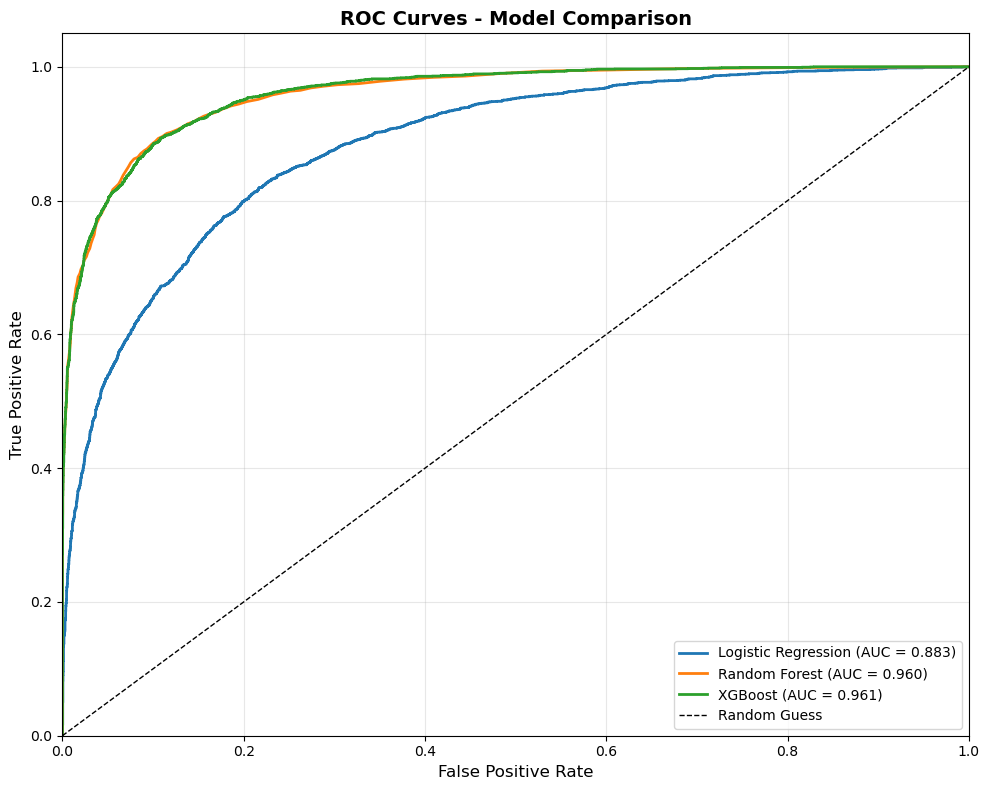

In [167]:
# ROC Curves for All Models
plt.figure(figsize=(10, 8))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_test)

plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {lr_test_roc_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {rf_test_roc_auc:.3f})')
plt.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {xgb_test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


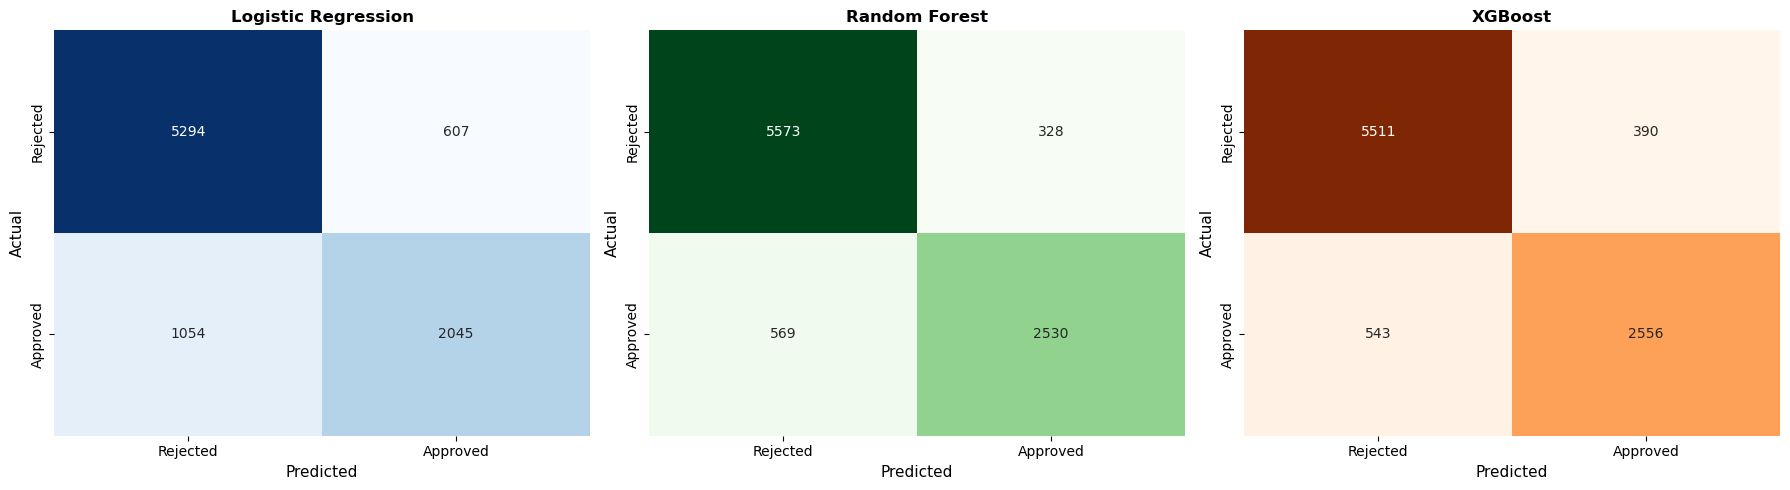

In [168]:
# Confusion matirx
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_lr = confusion_matrix(y_test, y_pred_test_binary)
cm_rf = confusion_matrix(y_test, rf_pred_test_binary)
cm_xgb = confusion_matrix(y_test, xgb_pred_test_binary)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
axes[0].set_title('Logistic Regression', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1],
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
axes[1].set_title('Random Forest', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axes[2],
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
axes[2].set_title('XGBoost', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Actual', fontsize=11)
axes[2].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()


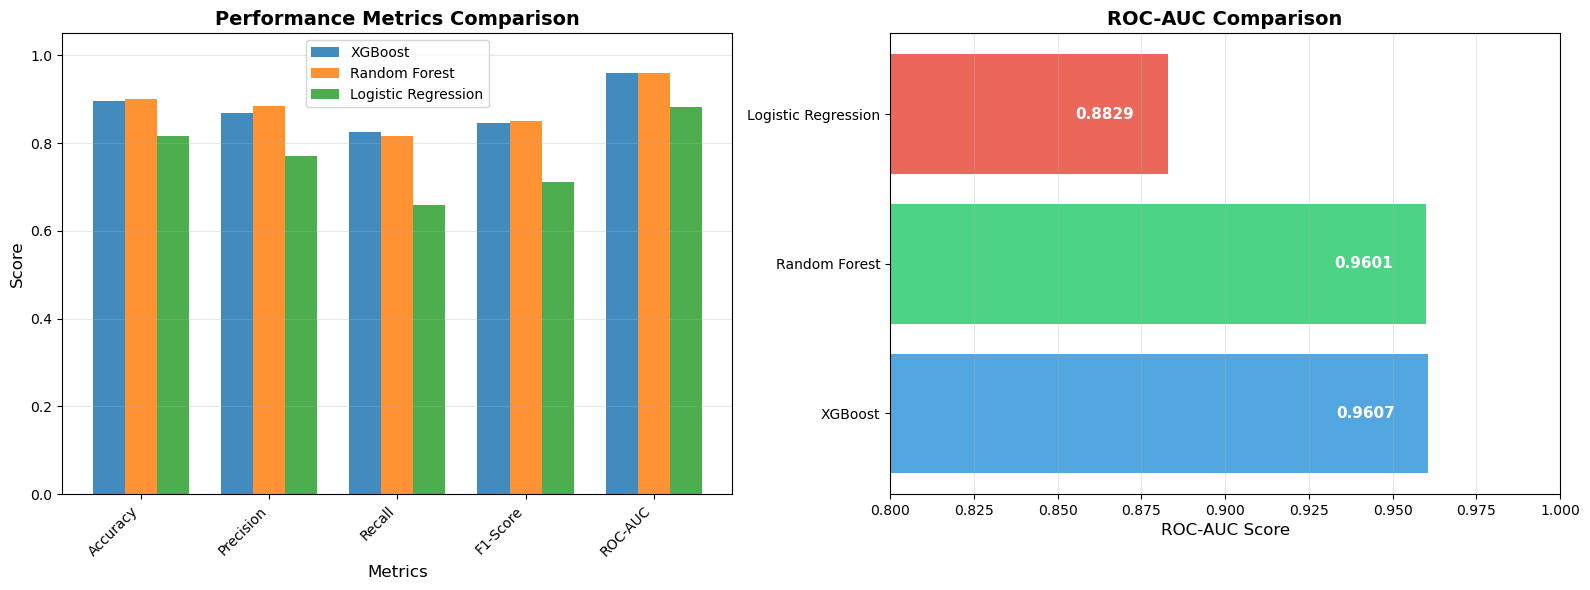

In [169]:
# final Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(metrics_to_plot))
width = 0.25

for idx, model in enumerate(comparison_df['Model']):
    values = comparison_df.loc[comparison_df['Model'] == model, metrics_to_plot].values[0]
    axes[0].bar(x_pos + idx*width, values, width, label=model, alpha=0.85)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.05])

models = comparison_df['Model']
roc_scores = comparison_df['ROC-AUC']
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = axes[1].barh(models, roc_scores, color=colors, alpha=0.85)
axes[1].set_xlabel('ROC-AUC Score', fontsize=12)
axes[1].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlim([0.80, 1.0])  
axes[1].grid(axis='x', alpha=0.3)

for bar in bars:
    width_val = bar.get_width()
    axes[1].text(width_val - 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width_val:.4f}', ha='right', va='center', 
                fontweight='bold', color='white', fontsize=11)

plt.tight_layout()
plt.show()

## Parameter tuning

In [170]:
# Initialize best parameters 
best_params_manual = {
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'n_jobs': -1
}
print(f"Initial parameters: {best_params_manual}")

Initial parameters: {'random_state': 42, 'use_label_encoder': False, 'eval_metric': 'logloss', 'n_jobs': -1}


### Tuning n_estimators (Number of Trees)

  n_estimators=50 - ROC-AUC: 0.9618
  n_estimators=100 - ROC-AUC: 0.9605


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  n_estimators=150 - ROC-AUC: 0.9590
  n_estimators=200 - ROC-AUC: 0.9578


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  n_estimators=300 - ROC-AUC: 0.9567

Selected n_estimators = 50 (ROC-AUC: 0.9618)


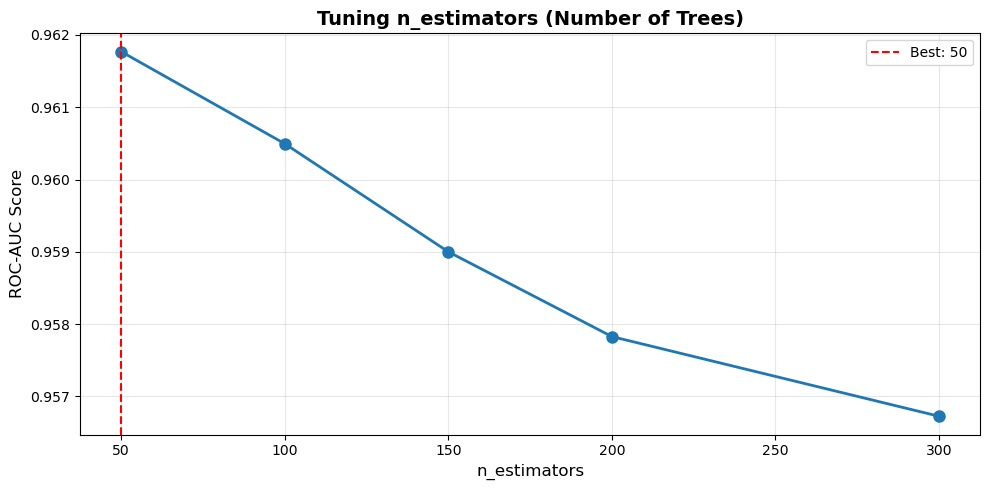

In [171]:
n_estimators_values = [50, 100, 150, 200, 300]
scores_n_estimators = []

for n_est in n_estimators_values:
    params = best_params_manual.copy()
    params['n_estimators'] = n_est
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)
    scores_n_estimators.append(score)
    
    print(f"  n_estimators={n_est} - ROC-AUC: {score:.4f}")

best_idx = np.argmax(scores_n_estimators)
best_n_estimators = n_estimators_values[best_idx]
best_params_manual['n_estimators'] = best_n_estimators

print(f"\nSelected n_estimators = {best_n_estimators} (ROC-AUC: {scores_n_estimators[best_idx]:.4f})")

plt.figure(figsize=(10, 5))
plt.plot(n_estimators_values, scores_n_estimators, marker='o', linewidth=2, markersize=8)
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Tuning n_estimators (Number of Trees)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(x=best_n_estimators, color='red', linestyle='--', label=f'Best: {best_n_estimators}')
plt.legend()
plt.tight_layout()
plt.show()


### Tuning max_depth (Maximum Tree Depth)

Tuning max_depth...
  max_depth=3 - ROC-AUC: 0.9644
  max_depth=4 - ROC-AUC: 0.9636
  max_depth=5 - ROC-AUC: 0.9634


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

  max_depth=6 - ROC-AUC: 0.9618
  max_depth=7 - ROC-AUC: 0.9613


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  max_depth=8 - ROC-AUC: 0.9602

Selected max_depth = 3 (ROC-AUC: 0.9644)


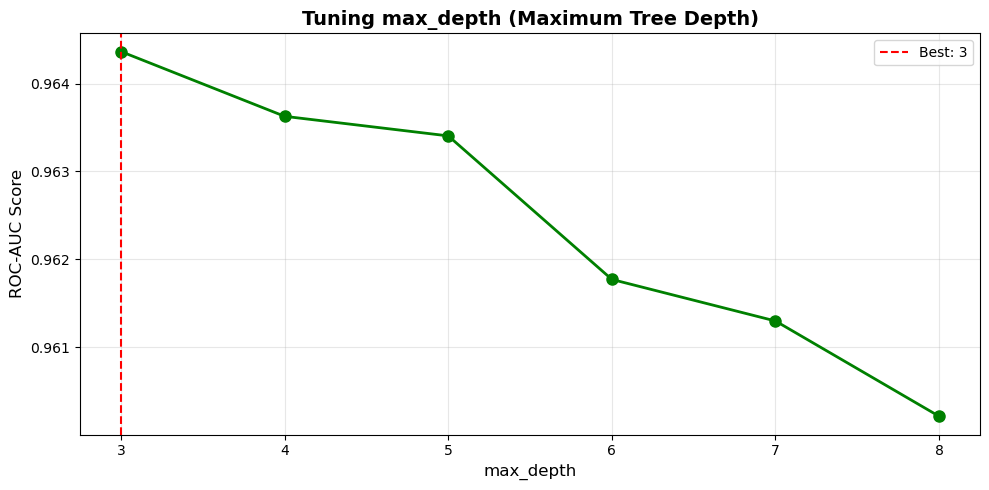

In [172]:
max_depth_values = [3, 4, 5, 6, 7, 8]
scores_max_depth = []

print("Tuning max_depth...")
for depth in max_depth_values:
    params = best_params_manual.copy()
    params['max_depth'] = depth
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)
    scores_max_depth.append(score)
    
    print(f"  max_depth={depth} - ROC-AUC: {score:.4f}")

best_idx = np.argmax(scores_max_depth)
best_max_depth = max_depth_values[best_idx]
best_params_manual['max_depth'] = best_max_depth

print(f"\nSelected max_depth = {best_max_depth} (ROC-AUC: {scores_max_depth[best_idx]:.4f})")

plt.figure(figsize=(10, 5))
plt.plot(max_depth_values, scores_max_depth, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Tuning max_depth (Maximum Tree Depth)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(x=best_max_depth, color='red', linestyle='--', label=f'Best: {best_max_depth}')
plt.legend()
plt.tight_layout()
plt.show()


### Tuning learning_rate (Step Size Shrinkage)

Tuning learning_rate...
  learning_rate=0.01 - ROC-AUC: 0.9350
  learning_rate=0.03 - ROC-AUC: 0.9479
  learning_rate=0.05 - ROC-AUC: 0.9579
  learning_rate=0.1 - ROC-AUC: 0.9633
  learning_rate=0.2 - ROC-AUC: 0.9645


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

  learning_rate=0.3 - ROC-AUC: 0.9644

Selected learning_rate = 0.2 (ROC-AUC: 0.9645)


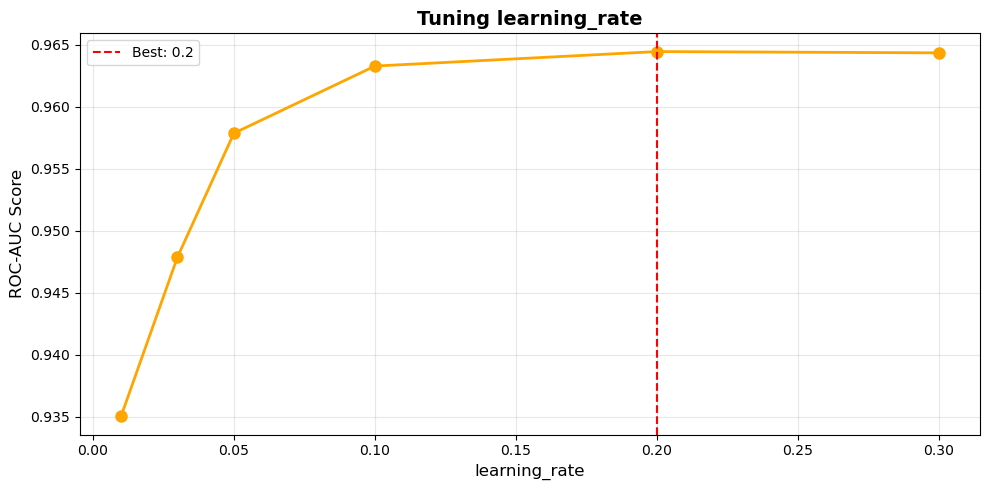

In [173]:
learning_rate_values = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3]
scores_learning_rate = []

print("Tuning learning_rate...")
for lr in learning_rate_values:
    params = best_params_manual.copy()
    params['learning_rate'] = lr
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)
    scores_learning_rate.append(score)
    
    print(f"  learning_rate={lr} - ROC-AUC: {score:.4f}")

best_idx = np.argmax(scores_learning_rate)
best_learning_rate = learning_rate_values[best_idx]
best_params_manual['learning_rate'] = best_learning_rate

print(f"\nSelected learning_rate = {best_learning_rate} (ROC-AUC: {scores_learning_rate[best_idx]:.4f})")

plt.figure(figsize=(10, 5))
plt.plot(learning_rate_values, scores_learning_rate, marker='o', linewidth=2, markersize=8, color='orange')
plt.xlabel('learning_rate', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Tuning learning_rate', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(x=best_learning_rate, color='red', linestyle='--', label=f'Best: {best_learning_rate}')
plt.legend()
plt.tight_layout()
plt.show()


### Tuning subsample (Fraction of Samples per Tree)

Tuning subsample...
  subsample=0.6 - ROC-AUC: 0.9648
  subsample=0.7 - ROC-AUC: 0.9648
  subsample=0.8 - ROC-AUC: 0.9646
  subsample=0.9 - ROC-AUC: 0.9645
  subsample=1.0 - ROC-AUC: 0.9645

Selected subsample = 0.6 (ROC-AUC: 0.9648)


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

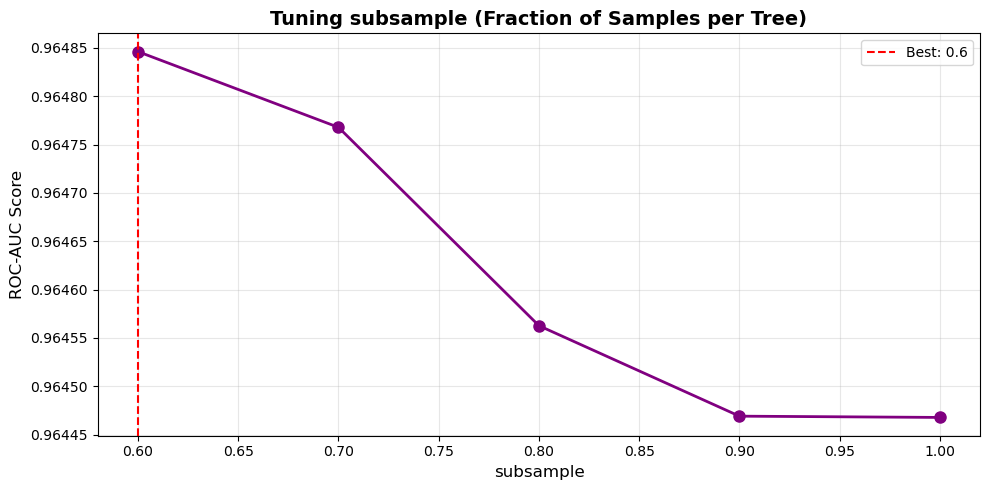

In [174]:
subsample_values = [0.6, 0.7, 0.8, 0.9, 1.0]
scores_subsample = []

print("Tuning subsample...")
for ss in subsample_values:
    params = best_params_manual.copy()
    params['subsample'] = ss
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)
    scores_subsample.append(score)
    
    print(f"  subsample={ss} - ROC-AUC: {score:.4f}")

best_idx = np.argmax(scores_subsample)
best_subsample = subsample_values[best_idx]
best_params_manual['subsample'] = best_subsample

print(f"\nSelected subsample = {best_subsample} (ROC-AUC: {scores_subsample[best_idx]:.4f})")

plt.figure(figsize=(10, 5))
plt.plot(subsample_values, scores_subsample, marker='o', linewidth=2, markersize=8, color='purple')
plt.xlabel('subsample', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Tuning subsample (Fraction of Samples per Tree)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(x=best_subsample, color='red', linestyle='--', label=f'Best: {best_subsample}')
plt.legend()
plt.tight_layout()
plt.show()


### Tuning colsample_bytree (Fraction of Features per Tree)

Tuning colsample_bytree...
  colsample_bytree=0.6 - ROC-AUC: 0.9637
  colsample_bytree=0.7 - ROC-AUC: 0.9645
  colsample_bytree=0.8 - ROC-AUC: 0.9649
  colsample_bytree=0.9 - ROC-AUC: 0.9649


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:46:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

  colsample_bytree=1.0 - ROC-AUC: 0.9648

Selected colsample_bytree = 0.9 (ROC-AUC: 0.9649)


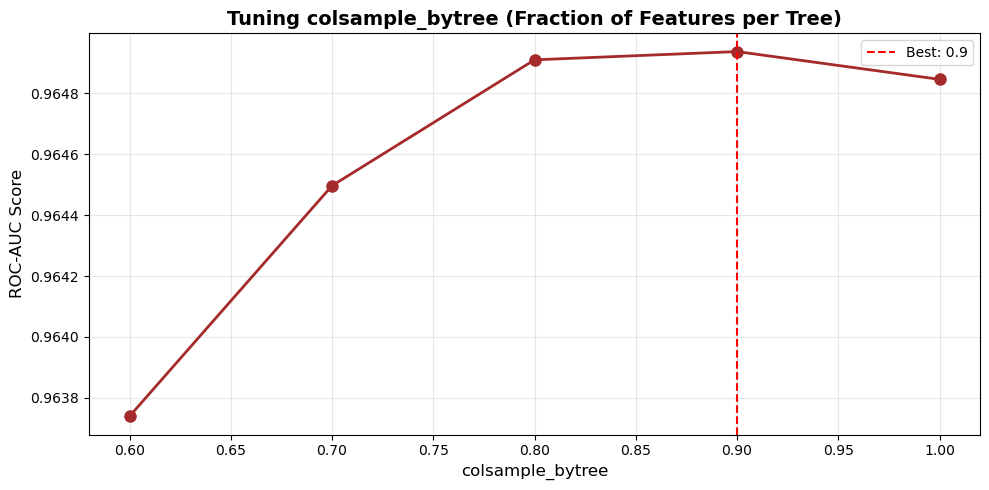

In [175]:
colsample_values = [0.6, 0.7, 0.8, 0.9, 1.0]
scores_colsample = []

print("Tuning colsample_bytree...")
for cs in colsample_values:
    params = best_params_manual.copy()
    params['colsample_bytree'] = cs
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)
    scores_colsample.append(score)
    
    print(f"  colsample_bytree={cs} - ROC-AUC: {score:.4f}")

best_idx = np.argmax(scores_colsample)
best_colsample = colsample_values[best_idx]
best_params_manual['colsample_bytree'] = best_colsample

print(f"\nSelected colsample_bytree = {best_colsample} (ROC-AUC: {scores_colsample[best_idx]:.4f})")

plt.figure(figsize=(10, 5))
plt.plot(colsample_values, scores_colsample, marker='o', linewidth=2, markersize=8, color='brown')
plt.xlabel('colsample_bytree', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Tuning colsample_bytree (Fraction of Features per Tree)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(x=best_colsample, color='red', linestyle='--', label=f'Best: {best_colsample}')
plt.legend()
plt.tight_layout()
plt.show()


### Tuning min_child_weight (Minimum Sum of Weights in Child)

Tuning min_child_weight...
  min_child_weight=1 - ROC-AUC: 0.9649
  min_child_weight=3 - ROC-AUC: 0.9647
  min_child_weight=5 - ROC-AUC: 0.9648
  min_child_weight=7 - ROC-AUC: 0.9648

Selected min_child_weight = 1 (ROC-AUC: 0.9649)


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

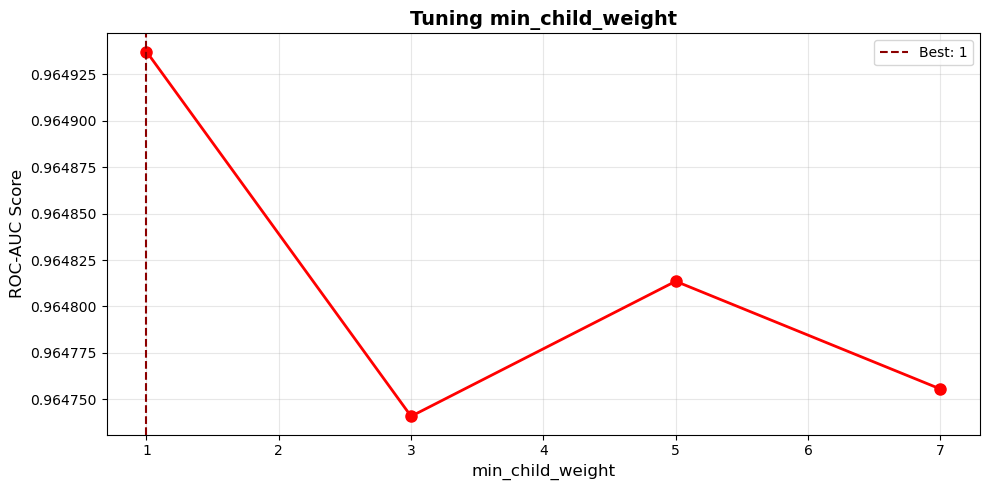

In [176]:
min_child_weight_values = [1, 3, 5, 7]
scores_min_child = []

print("Tuning min_child_weight...")
for mcw in min_child_weight_values:
    params = best_params_manual.copy()
    params['min_child_weight'] = mcw
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)
    scores_min_child.append(score)
    
    print(f"  min_child_weight={mcw} - ROC-AUC: {score:.4f}")

best_idx = np.argmax(scores_min_child)
best_min_child_weight = min_child_weight_values[best_idx]
best_params_manual['min_child_weight'] = best_min_child_weight

print(f"\nSelected min_child_weight = {best_min_child_weight} (ROC-AUC: {scores_min_child[best_idx]:.4f})")

plt.figure(figsize=(10, 5))
plt.plot(min_child_weight_values, scores_min_child, marker='o', linewidth=2, markersize=8, color='red')
plt.xlabel('min_child_weight', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Tuning min_child_weight', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(x=best_min_child_weight, color='darkred', linestyle='--', label=f'Best: {best_min_child_weight}')
plt.legend()
plt.tight_layout()
plt.show()


### Tuning gamma (Minimum Loss Reduction)

Tuning gamma...
  gamma=0 - ROC-AUC: 0.9649
  gamma=0.1 - ROC-AUC: 0.9649
  gamma=0.2 - ROC-AUC: 0.9649
  gamma=0.3 - ROC-AUC: 0.9649
  gamma=0.5 - ROC-AUC: 0.9649

Selected gamma = 0 (ROC-AUC: 0.9649)


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

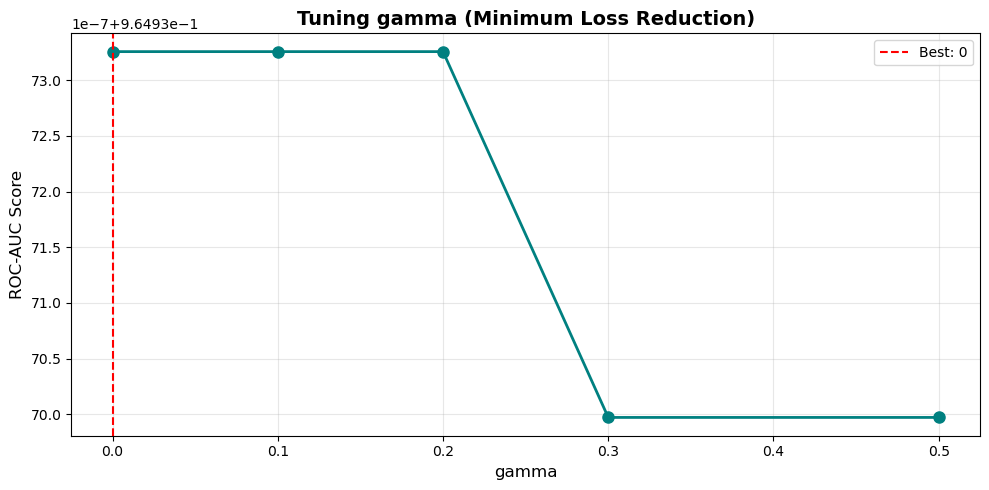

In [177]:
gamma_values = [0, 0.1, 0.2, 0.3, 0.5]
scores_gamma = []

print("Tuning gamma...")
for g in gamma_values:
    params = best_params_manual.copy()
    params['gamma'] = g
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)
    scores_gamma.append(score)
    
    print(f"  gamma={g} - ROC-AUC: {score:.4f}")

best_idx = np.argmax(scores_gamma)
best_gamma = gamma_values[best_idx]
best_params_manual['gamma'] = best_gamma

print(f"\nSelected gamma = {best_gamma} (ROC-AUC: {scores_gamma[best_idx]:.4f})")

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, scores_gamma, marker='o', linewidth=2, markersize=8, color='teal')
plt.xlabel('gamma', fontsize=12)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.title('Tuning gamma (Minimum Loss Reduction)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(x=best_gamma, color='red', linestyle='--', label=f'Best: {best_gamma}')
plt.legend()
plt.tight_layout()
plt.show()


### Final Model with All Best Parameters 

In [178]:

print("FINAL SELECTED PARAMETERS\n")
for param, value in best_params_manual.items():
    if param not in ['random_state', 'use_label_encoder', 'eval_metric', 'n_jobs']:
        print(f"  {param}: {value}")

final_model_manual = XGBClassifier(**best_params_manual)
final_model_manual.fit(X_train, y_train)

y_pred_val_final = final_model_manual.predict_proba(X_val)[:, 1]
y_pred_val_binary = (y_pred_val_final >= 0.5).astype(int)

print("\nVALIDATION SET PERFORMANCE:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_val_binary):.4f}")
print(f"  Precision: {precision_score(y_val, y_pred_val_binary):.4f}")
print(f"  Recall:    {recall_score(y_val, y_pred_val_binary):.4f}")
print(f"  F1-Score:  {f1_score(y_val, y_pred_val_binary):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_pred_val_final):.4f}")

y_pred_test_final = final_model_manual.predict_proba(X_test)[:, 1]
y_pred_test_binary = (y_pred_test_final >= 0.5).astype(int)

print("\nTEST SET PERFORMANCE:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_test_binary):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_test_binary):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_test_binary):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_test_binary):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_pred_test_final):.4f}")


FINAL SELECTED PARAMETERS

  n_estimators: 50
  max_depth: 3
  learning_rate: 0.2
  subsample: 0.6
  colsample_bytree: 0.9
  min_child_weight: 1
  gamma: 0

VALIDATION SET PERFORMANCE:
  Accuracy:  0.9069
  Precision: 0.8813
  Recall:    0.8426
  F1-Score:  0.8615
  ROC-AUC:   0.9649

TEST SET PERFORMANCE:
  Accuracy:  0.9044
  Precision: 0.8822
  Recall:    0.8338
  F1-Score:  0.8573
  ROC-AUC:   0.9644


/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:47:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Saving the Model and DictVectorizer

In [179]:
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(final_model_manual, f)

with open('dv.pkl', 'wb') as f:
    pickle.dump(dv, f)

print('Model saved')

Model saved


## Loading and testing the Model

In [180]:
with open('xgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
with open('dv.pkl', 'rb') as f:
    loaded_dv = pickle.load(f)


sample = df_test.iloc[435].to_dict()


print("Testing on this customer:\n")
for key, value in sample.items():
    print(f"{key:30s}: {value}")

X_sample = loaded_dv.transform([sample])
pred = loaded_model.predict(X_sample)[0]
prob = loaded_model.predict_proba(X_sample)[0, 1]

print(f'\nPrediction: {pred}')
print(f'Probability of default: {prob:.2%}')
print(f'Result: {"APPROVED" if pred == 0 else "DEFAULT"}')


Testing on this customer:

person_age                    : 24.0
person_gender                 : male
person_education              : Associate
person_income                 : 80413.0
person_emp_exp                : 3
person_home_ownership         : MORTGAGE
loan_amnt                     : 30000.0
loan_intent                   : MEDICAL
loan_int_rate                 : 19.42
loan_percent_income           : 0.3730740054468804
cb_person_cred_hist_length    : 3.0
credit_score                  : 611
previous_loan_defaults_on_file: Yes

Prediction: 1
Probability of default: 99.97%
Result: DEFAULT
